# The Variational Quantum Eigensolver algorithm

In this notebook we are going to see an example of the Variational Quantum Eigensolver algorithm, a hybrid algorithm presented for the first time by [Peruzzo et al. in 2014](https://www.nature.com/articles/ncomms5213). 

This algorithm can be used, as we are going to see, to [find out the ground state energy of physical and chemical systems](https://www.nature.com/articles/nature23879).

In [66]:
# Import useful quantities 

import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit.circuit import QuantumCircuit,ClassicalRegister, QuantumRegister

import itertools


# Some new useful methods

from Hamiltonian import generate_XYZ
# from ansatz import *


from qiskit.opflow.gradients           import Gradient
from qiskit.opflow.state_fns           import CircuitStateFn, StateFn
from qiskit.opflow.expectations        import PauliExpectation
from qiskit.opflow.converters          import CircuitSampler

We are going to study the Ising Hamiltonian with XX interactions and a magnetic field in the z direction, using the VQE to find its ground state energy.

### How does the algorithm works?

Consider a system with Hamiltonian $H$, we know that its ground state energy is 

\begin{equation}
E_{0} = \langle \psi_{0} | H | \psi_{0} \rangle \leq \langle \psi | H | \psi \rangle \quad \quad \forall |\psi \rangle
\end{equation}

considering both $|\psi_0 \rangle$ and $|\psi \rangle$ normalized. This means that every state we are going to prepare on our quantum computer will have an expectation value of the Hamiltonian operator (energy) greater or equal than the ground state energy. This is known as the variational principle and let us find the ground state energy as a optimization problem, in which the function to minimize is 

\begin{equation}
L(\psi) = \langle \psi | H | \psi \rangle
\end{equation}

But how can we effectively minimize this function with the aid of a quantum computer?

- As a first thing, we consider an ansatz of the wavefunction describing the state of the system, which will depend upon some parametrized quantum gates in the case of a quantum computer, obtaining the parametrized state $U(w)|\psi \rangle =|\psi(w) \rangle $
- then we are going to measure the energy of this state and its gradient with respect to the parameters using the quantum computer
- we will feed these information to a classical computer, which will perform the optimization of the parameters by using classical optimization strategies such as gradient descent
- the newly optimized parameters are then used to prepare a new quantum state on which we are going to measure again energy and gradient. This procedure is repeated until convergence of the algorithm.

### The Ising hamiltonian
In this challenge we would like to compute the groundstate of the Transverse field Ising model given by the Hamiltonian
\begin{equation}
H=J_z\sum_{i=0}^{N-1}\sigma_i^z\sigma_{i+1}^z + h\sum_{i=1}^{N}\sigma_i^x,
\end{equation}
where we will assume periodic boundary conditions (pbc). In this exercice, you would need to implement the VQE algorithm to compute the groundstate energy as a function of h. You will then use it to compute the first excited states in order to explore the phase transition from the antiferromagnetic to the ferromagnetic phase. 
 

In [20]:
H = generate_XYZ(J_x=0, J_y=0,J_z=1,field=1,n_spins=3,pbc=True)


### The Ansatz
Now that we have the Hamiltonian operator, we will need an ansatz for our wavefunction. In quantum computing, an ansatz is a circuit that at the end will produce a qubit state $|\psi \rangle$. In this case, we need a variational ansatz, so some gates will contains parameters that are going to be iteratively optimized (as an example, rotation on the $x,y,z$ axis).

There is no analytical way to choose an ansatz for the system: there are empirical rules based on similarity with what we are studying.
Some ans&auml;tze come from classical computational chemistry, such as the highly accurate [q-UCCSD](https://arxiv.org/pdf/1506.00443.pdf),  but mostly we have to consider some circuits that can be run on current devices, so they have to contain few two qubits gates and be relatively shallow: these ans&auml;tze are called hardware-efficient.


What we are going to consider is one of the so-called hardware-efficient ans&auml;tze. 
The system does not contain many qubits, so our trial ansatz will be very simple : a layer of rotations around the $y$-axis followed by CNOTs and again a layer of rotations. This simple structure can be easily extended both in depth (adding more CNOTs and rotation) and in width, to study bigger system, therefore is widely used.

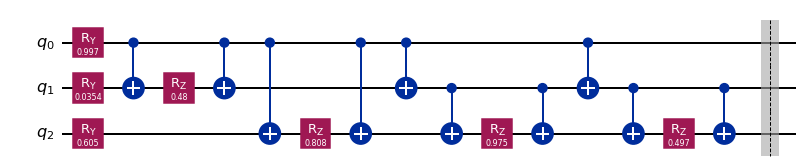

In [9]:
#Draw an example


example = feature_map_ansatz(np.random.rand(7),n_spins=3,n_layer=1,full_rotation=False)
example.draw('mpl', style={'name': 'iqx'})

### Measuring the Energy

We want a circuit to measure the expecation value of the Hamiltonian on our trial state

In [90]:
def energy(n_qubits,n_layer, op,ansatz,params,shots,instance):
    
    #Make the operator measurable
    op = StateFn(op,is_measurement = True)
    
    # create the wavefunction
    wfn = CircuitStateFn(ansatz(parameter=params,n_spins=n_qubits,n_layer=n_layer,full_rotation=False))
    braket = op @ wfn  #matrix product
    
    # Simulate the sampling
    grouped = PauliExpectation().convert(braket)
    sampled_op = CircuitSampler(instance).convert(grouped)
    
    # Expectation value
    mean_value = sampled_op.eval().real
    est_err = 0
    
    # If the simulations is not unitary evolution, return an error bar
    if (not instance.is_statevector):
        variance = PauliExpectation().compute_variance(sampled_op).real
        est_err  = np.sqrt(variance/shots)

    return mean_value, est_err

### Measuring derivatives

Now things get interesting! In order to optimize our parameters, a quantum computer has to give to classical optimizer important information such as first- or second-order derivatives! But how can we measure the derivative wrt to a specific parameter on a quantum circuit?

$$
\frac{\partial }{\partial w_i} L(w) = \frac{\partial }{\partial w_i} \langle \psi(w) | H | \psi(w) \rangle
$$

many different methods have been proposed recently, in this case we are going to see a method  that is called _parameter shift_:

- assume that every parametrized gate is of the form $$ U_j(w_j) = e^{-i w_j G_j}= \cos(w_j)\mathbf{I} -i \sin(w_j)G_j$$ where $G_j$ is an operator such that $G_{j}^{2} = \mathbf{I}$

- then the derivative can be expressed as $$ \frac{\partial }{\partial w_i} L(w) = \frac{L(w+ e_i s)-L(w-e_is)}{2\sin(s)}  $$ where $s \in \mathbf{R}$ and $e_i$ indicates the versor in the $i$-th direction. In our case we are going to consider $s= \frac{\pi}{2}$.

This means that to calculate the gradient with $N_p$ parameters, we have to measure $H$ on $2N_p$ different circuits, but it's possible!

Note that the assumption we made is quite general: $G_j$ could be every tensor product of Pauli operators



In [91]:
#useful function to shift the parameters
def ei(i,n):
    vi = np.zeros(n)
    vi[i] = 1.0
    return vi[:]


def gradient(n_qubits,n_layer,op,ansatz,params,shots,instance):
    
    n_params = len(params)
    wfn_circuits = []
    op = StateFn(op,is_measurement = True)
    
    for i in range(n_params):
        wfn_circuits.append(CircuitStateFn(ansatz(params+ei(i,n_params)*np.pi/2.0,n_spins=n_qubits,n_layer=n_layer,full_rotation=False)))
        wfn_circuits.append(CircuitStateFn(ansatz(params-ei(i,n_params)*np.pi/2.0,n_spins=n_qubits,n_layer=n_layer,full_rotation=False)))

    # Now measure circuits
    results = []
    for wfn in wfn_circuits:
        braket = op @ wfn
    
        # Simulate the sampling
        grouped = PauliExpectation().convert(braket)
        sampled_op = CircuitSampler(instance).convert(grouped)
    
        # Expectation value
        mean_value = sampled_op.eval().real
        est_err = 0
    
        # If the simulations is not unitary evolution, return an error bar
        if (not instance.is_statevector):
            variance = PauliExpectation().compute_variance(sampled_op).real
            est_err  = np.sqrt(variance/shots)

        results.append([mean_value, est_err])
    
    g = np.zeros((n_params,2))
    for i in range(n_params):
        rplus  = results[2*i]
        rminus = results[2*i+1]
        # G      = (Ep - Em)/2
        # var(G) = var(Ep) * (dG/dEp)**2 + var(Em) * (dG/dEm)**2
        g[i,:] = (rplus[0]-rminus[0])/2.0,np.sqrt(rplus[1]**2+rminus[1]**2)/2.0

    return g

### The algorithm

Now we declare a function to repeat iteratively the procedure of measuring energy, its gradient and then optimizing the parameters using a standard gradient descent technique, namely $$ w_{new}= w_{old} - \eta \nabla_{w} L(w)$$ with $\eta \in \mathbf{R}$ as the learning rate.

In [ ]:
def VQE(n_qubits,n_layer,op,ansatz,params,shots,instance,lr,n_reps):
    
    log ={}
    log['energies'] = []
    log['err_energies'] = []
    log['gradients'] = []
    
    curr_params = params
    for i in range(n_reps):
        #Measure energy and save it
        
        E = energy(n_qubits,n_layer,op,ansatz,curr_params,shots,instance)
        if i%10==0
            print('Run number: ',i+1)
            print('Energy:', E[0])
            print('========================= \n')
        log['energies'].append(E[0])
        log['err_energies'].append(E[1])
        
        #Measure gradients
        g = gradient(n_qubits,n_layer,op,ansatz,curr_params,shots,instance)
        
        log['gradients'].append(g[:,0])
#         print(g)
        
        #Update parameters
        
        curr_params = curr_params - lr*g[:,0]
        
    return log

### Run and plots the results

In [117]:
from qiskit import Aer
from qiskit.utils import QuantumInstance

backend = Aer.get_backend('statevector_simulator')
qinstance = QuantumInstance(backend, seed_simulator=2, seed_transpiler=2)



# Fix important parameters and the instance

n_qubits = 3
params   = np.zeros(4)
shots    = 1
n_reps   = 100
lr       = 0.05
n_layer  = 4

length = n_layer*(n_qubits + len(possible_pair('full',2,n_qubits)))
params   = np.random.rand(length)




In [118]:
res = VQE(n_qubits,n_layer,H,feature_map_ansatz,params,shots,qinstance,lr,n_reps)

Run number:  1
Energy: 1.5151348481280031

Run number:  2
Energy: 1.276077593907487

Run number:  3
Energy: 1.0483817494469254

Run number:  4
Energy: 0.8297112846599155

Run number:  5
Energy: 0.6151534511765689

Run number:  6
Energy: 0.3982698342724487

Run number:  7
Energy: 0.17189591123291026

Run number:  8
Energy: -0.07096083909448325

Run number:  9
Energy: -0.33572098616670343

Run number:  10
Energy: -0.624121798521921

Run number:  11
Energy: -0.9317744737788952

Run number:  12
Energy: -1.2467858394323938

Run number:  13
Energy: -1.5514455857253626

Run number:  14
Energy: -1.8275211479570481

Run number:  15
Energy: -2.0623741546278667

Run number:  16
Energy: -2.2518385513917396

Run number:  17
Energy: -2.398846928955827

Run number:  18
Energy: -2.510145079537699

Run number:  19
Energy: -2.5934700519894687

Run number:  20
Energy: -2.6559292296439114

Run number:  21
Energy: -2.7033390593644344

Run number:  22
Energy: -2.7401244222779653

Run number:  23
Energy: -2.

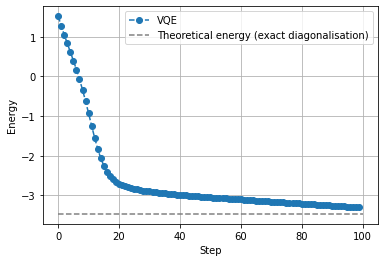

In [123]:
##Plot the results

steps = list(range(n_reps))

plt.plot(steps,res['energies'],marker='o',linestyle='dashed',label='VQE')
plt.hlines(-3.46410162, xmin= 0.0, xmax=  100,label='Theoretical energy (exact diagonalisation)',linestyle ='dashed',color='grey')
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)

plt.show()

### References for VQE in Qiksit

- For the [method](https://qiskit.org/documentation/stubs/qiskit.aqua.algorithms.VQE.html) 
- For the [optimizers](https://qiskit.org/documentation/apidoc/qiskit.aqua.components.optimizers.html)